# Push Notificactions  
Predictive model: People interested in a product.  
Given a user and a product, predict if the wuold buy it if theywere buying at that moment.  
user with basket > 5 products
Linear model

In [32]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.figure
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
import sklearn.linear_model 

import joblib

pd.options.display.max_columns = None

## Functions

In [66]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: tuple[matplotlib.figure.Figure, np.array] = None,
        model_estimator = None, #sklearn.linear_model
        x_train: pd.DataFrame = None,
        y_train: pd.Series = None
):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1,2, figsize=(14,7))
    else:
        fig, ax = figure
    
    #print(f"classification_report model {model_name}: ", classification_report(y_test, y_pred))

    if model_estimator is not None:
        print(f"Cross Validation mean: {cross_val_score(model_estimator, x_train, y_train, cv=5).mean()}")


    ax[0].plot(recall, precision, label=f"{model_name}: AUC:{pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(F"precision-recall Curve")
    ax[0].legend()

    ax[1].plot(fpr,tpr,label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC Curve")
    ax[1].legend()

In [34]:
def treatment_columns_categorical_encoding(
        dataframe: pd.DataFrame,
        column: str
    ):
    dataframe = pd.concat([dataframe, pd.get_dummies(dataframe[column])],axis=1)
    dataframe = dataframe.drop(column,axis=1)
    return dataframe

### Load the data

In [35]:
#folder_path = Path("D:/Users/maick/Desktop/Codigos/zrive-ds/data/box_builder_dataset/feature_frame.csv")
folder_path = Path("C:/Users/AULA04/Desktop/Codes/zrive-ds/data/box_builder_dataset/feature_frame.csv")

In [ ]:
feature_frame = pd.read_csv(folder_path)
feature_frame

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880547,33826439594116,healthcarevitamins,3643294515332,3906490826884,2021-03-03 14:30:30,2021-03-03 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


## Preparation of the dataset

Filter for >5 products

In [37]:
size_of_order = feature_frame.groupby("order_id").outcome.sum()
size_of_order = size_of_order[size_of_order>=5]
feature_frame = feature_frame[feature_frame["order_id"].isin(size_of_order.index)]
feature_frame

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880541,33826439594116,healthcarevitamins,3643241300100,3864791220356,2021-03-03 12:56:04,2021-03-03 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,colief,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [38]:
(feature_frame["outcome"]).value_counts()

outcome
0.0    2132624
1.0      31329
Name: count, dtype: int64

pass to datetime

In [39]:
feature_frame["created_at"] = pd.to_datetime(feature_frame["created_at"])
feature_frame["order_date"] = pd.to_datetime(feature_frame["order_date"]).dt.date

C:\Users\AULA04\AppData\Local\Temp\ipykernel_8076\3793107625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_frame["created_at"] = pd.to_datetime(feature_frame["created_at"])
C:\Users\AULA04\AppData\Local\Temp\ipykernel_8076\3793107625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_frame["order_date"] = pd.to_datetime(feature_frame["order_date"]).dt.date


In [40]:
orders_diary = feature_frame.groupby("order_date").order_id.nunique()
porcentaje_orders_dairy = orders_diary.cumsum() / orders_diary.sum()
train_val_cutoff = porcentaje_orders_dairy[porcentaje_orders_dairy<=0.7].idxmax()
val_test_cutoff = porcentaje_orders_dairy[porcentaje_orders_dairy<=0.9].idxmax()
print(f"The 70% of orders were before the {train_val_cutoff}")
print(f"The 90% of orders were before the {val_test_cutoff}")

The 70% of orders were before the 2021-02-04
The 90% of orders were before the 2021-02-22


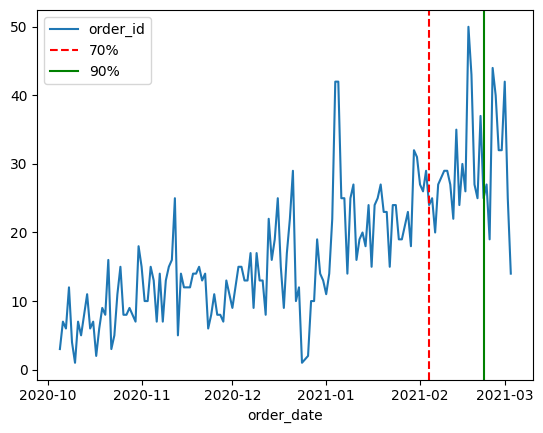

In [41]:
orders_diary.plot(kind="line")
plt.axvline(x=pd.to_datetime(train_val_cutoff), color='red', linestyle='--', label="70%")
plt.axvline(x=pd.to_datetime(val_test_cutoff), color='green', linestyle='-', label="90%")
plt.legend()

In [43]:
feature_frame = (feature_frame.sort_values("order_date",ascending=True).reset_index()).drop("index",axis = 1)
feature_frame

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33667182035076,shavinggrooming,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2,33667182035076,shavinggrooming,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
3,33667182035076,shavinggrooming,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
4,33667209199748,dishwasherdetergent,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.067498,0.160643,ecover,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163948,34276570824836,condimentsdressings,3643294515332,3906490826884,2021-03-03 14:30:30,2021-03-03,2,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,aspall,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163949,34276570824836,condimentsdressings,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03,7,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,aspall,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,40.0,30.0,26.081884
2163950,34276570824836,condimentsdressings,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03,4,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,aspall,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163951,33826456961156,babyfood6months,3643229274244,3536923295876,2021-03-03 12:36:28,2021-03-03,4,0.0,0.0,0.0,0.0,0.0,0.034969,0.155039,annabelkarmel,0.000714,2.0,0.0,0.0,0.0,2.0,33.0,51.0,20.825465,30.0,30.0,18.973072


### Columns no numeric

#### Product type

In [12]:
#Product type: categorical encoding
#vendor: categorical encoding

In [44]:
"""### Delete: 
* user_id
* variant_id
* order_date
* created_at
* order_ID"""
feature_frame = feature_frame.drop("variant_id",axis=1)
feature_frame = feature_frame.drop("user_id",axis=1)
feature_frame = feature_frame.drop("created_at",axis=1)
feature_frame = feature_frame.drop("order_id",axis=1)

In [45]:
feature_frame.head(5)

,product_type,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,ricepastapulses,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.0,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,shavinggrooming,2020-10-05,4,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.0,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2,shavinggrooming,2020-10-05,2,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.0,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
3,shavinggrooming,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,bulldog,0.0,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
4,dishwasherdetergent,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.067498,0.160643,ecover,0.0,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947


### Separate the dataframe

In [46]:
column_numerics = []
for columns in feature_frame.dtypes:
    if columns == "int64" or columns == "float64":
        column_numerics.append(True)
    else:
        column_numerics.append(False)

feature_frame_numeric = feature_frame.loc[:, column_numerics]
feature_frame_numeric

,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,4,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2,2,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
3,3,0.0,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
4,3,0.0,0.0,0.0,0.0,0.0,0.067498,0.160643,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163948,2,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163949,7,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,40.0,30.0,26.081884
2163950,4,0.0,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163951,4,0.0,0.0,0.0,0.0,0.0,0.034969,0.155039,0.000714,2.0,0.0,0.0,0.0,2.0,33.0,51.0,20.825465,30.0,30.0,18.973072


## Divide the dataset

In [77]:
y = feature_frame_numeric["outcome"]
x = feature_frame_numeric.drop(columns=["outcome"])

In [78]:
x

,user_order_seq,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,3,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,4,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2,2,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
3,3,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
4,3,0.0,0.0,0.0,0.0,0.067498,0.160643,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163948,2,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163949,7,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,40.0,30.0,26.081884
2163950,4,0.0,0.0,0.0,0.0,0.045812,0.094675,0.002857,2.0,0.0,0.0,0.0,2.0,33.0,32.0,26.712393,30.0,30.0,26.081884
2163951,4,0.0,0.0,0.0,0.0,0.034969,0.155039,0.000714,2.0,0.0,0.0,0.0,2.0,33.0,51.0,20.825465,30.0,30.0,18.973072


I try two ways to divide the dataset to view the diferent results
1. Randomly, 10% data for test, aprox 20% for valid and aprox 80% for train 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state=42)

print(f"Train: {len(X_train)} ")
print(f"Valid: {len(X_valid)} ")
print(f"Test: {len(X_test)} ") 

2. Temporarily, where the 70% goes until 2021-02-04 division for test and valid goes until 2021-02-22

In [48]:
x_train = x.iloc[:int(x.shape[0]*0.7)]
x_test = x.iloc[int(x.shape[0]*0.7):int(y.shape[0]*0.9)]
x_valid = x.iloc[int(x.shape[0]*0.9):]

y_train = y.iloc[:int(y.shape[0]*0.7)]
y_test = y.iloc[int(y.shape[0]*0.7):int(y.shape[0]*0.9)]
y_valid = y.iloc[int(y.shape[0]*0.9):]

In [49]:
x_train.shape[0]+x_test.shape[0]+x_valid.shape[0] == x.shape[0]

True

In [50]:
y_train.shape[0]+y_test.shape[0]+y_valid.shape[0] == y.shape[0]

True

In [51]:
x_train

,user_order_seq,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,3,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,4,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
2,2,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
3,3,0.0,0.0,0.0,0.0,0.140689,0.115607,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,18.536001,30.0,35.0,27.143111
4,3,0.0,0.0,0.0,0.0,0.067498,0.160643,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,41.0,30.498299,30.0,32.0,25.841947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514762,9,0.0,0.0,0.0,0.0,0.365682,0.134173,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,56.0,27.693045,10.0,25.0,21.048990
1514763,2,0.0,0.0,0.0,0.0,0.365682,0.134173,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,56.0,27.693045,12.0,25.0,21.048990
1514764,2,0.0,0.0,0.0,0.0,0.365682,0.134173,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,56.0,27.693045,22.0,25.0,21.048990
1514765,5,0.0,0.0,0.0,0.0,0.062076,0.091703,0.001596,2.0,0.0,0.0,2.0,2.0,33.0,52.0,29.852016,30.0,36.0,29.372186


In [52]:
y_train

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1514762    0.0
1514763    0.0
1514764    0.0
1514765    0.0
1514766    0.0
Name: outcome, Length: 1514767, dtype: float64

Normalization

In [53]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=x.columns)
x_train

,user_order_seq,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,0.066667,0.0,0.0,0.0,0.0,0.066116,0.068601,0.000000,0.25,0.0,0.0,0.000000,0.25,0.261905,0.500000,0.518891,0.236220,0.707692,0.653626
1,0.133333,0.0,0.0,0.0,0.0,0.126722,0.114077,0.000000,0.25,0.0,0.0,0.000000,0.25,0.261905,0.488095,0.298937,0.236220,0.861538,0.740997
2,0.000000,0.0,0.0,0.0,0.0,0.126722,0.114077,0.000000,0.25,0.0,0.0,0.000000,0.25,0.261905,0.488095,0.298937,0.236220,0.861538,0.740997
3,0.066667,0.0,0.0,0.0,0.0,0.126722,0.114077,0.000000,0.25,0.0,0.0,0.000000,0.25,0.261905,0.488095,0.298937,0.236220,0.861538,0.740997
4,0.066667,0.0,0.0,0.0,0.0,0.052342,0.147059,0.000000,0.25,0.0,0.0,0.000000,0.25,0.261905,0.488095,0.507791,0.236220,0.769231,0.701343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514762,0.466667,0.0,0.0,0.0,0.0,0.355372,0.127674,0.000000,0.25,0.0,0.0,0.000000,0.25,0.261905,0.666667,0.458813,0.078740,0.553846,0.555277
1514763,0.000000,0.0,0.0,0.0,0.0,0.355372,0.127674,0.000000,0.25,0.0,0.0,0.000000,0.25,0.261905,0.666667,0.458813,0.094488,0.553846,0.555277
1514764,0.000000,0.0,0.0,0.0,0.0,0.355372,0.127674,0.000000,0.25,0.0,0.0,0.000000,0.25,0.261905,0.666667,0.458813,0.173228,0.553846,0.555277
1514765,0.200000,0.0,0.0,0.0,0.0,0.046832,0.096571,0.003752,0.25,0.0,0.0,0.333333,0.25,0.261905,0.619048,0.496508,0.236220,0.892308,0.808928


### Baseline

In [76]:
predicciones_binarias = (feature_frame["global_popularity"] >= 0.5).astype(int)

# Calcula el classification report utilizando las predicciones binarias
print("Validación:\n", classification_report(feature_frame["outcome"], predicciones_binarias))


c:\Users\AULA04\AppData\Local\pypoetry\Cache\virtualenvs\zrive-ds-qOtEqhAW-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AULA04\AppData\Local\pypoetry\Cache\virtualenvs\zrive-ds-qOtEqhAW-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validación:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   2132624
         1.0       0.00      0.00      0.00     31329

    accuracy                           0.99   2163953
   macro avg       0.49      0.50      0.50   2163953
weighted avg       0.97      0.99      0.98   2163953



c:\Users\AULA04\AppData\Local\pypoetry\Cache\virtualenvs\zrive-ds-qOtEqhAW-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
print("Validación:\n", classification_report(feature_frame["outcome"], feature_frame["global_popularity"]))

plot_metrics("popularity baseline", y_pred=feature_frame["global_popularity"], y_test=feature_frame["outcome"])

ValueError: Classification metrics can't handle a mix of binary and continuous targets

### LogisticRegression

In [54]:
LogReg_model = LogisticRegression(
    class_weight="balanced", 
    random_state=42,
    )

LogReg_model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [69]:
y_test_pred = LogReg_model.predict(x_test)
print("Validación:\n", classification_report(y_test, y_test_pred))

Validación:
               precision    recall  f1-score   support

         0.0       0.99      0.94      0.96    426947
         1.0       0.02      0.08      0.03      5843

    accuracy                           0.93    432790
   macro avg       0.50      0.51      0.50    432790
weighted avg       0.97      0.93      0.95    432790



In [71]:
cross_val_score(LogReg_model, x_train, y_train, cv=5).mean()

0.8434234792268684

In [73]:
cross_val_score(LogReg_model, x_train, y_train, cv=5, scoring='recall').mean()

0.6269337287137255

classification_report model LogisticRegression:                precision    recall  f1-score   support

         0.0       0.99      0.94      0.96    426947
         1.0       0.02      0.08      0.03      5843

    accuracy                           0.93    432790
   macro avg       0.50      0.51      0.50    432790
weighted avg       0.97      0.93      0.95    432790

Cross Validation mean: 0.8434234792268684


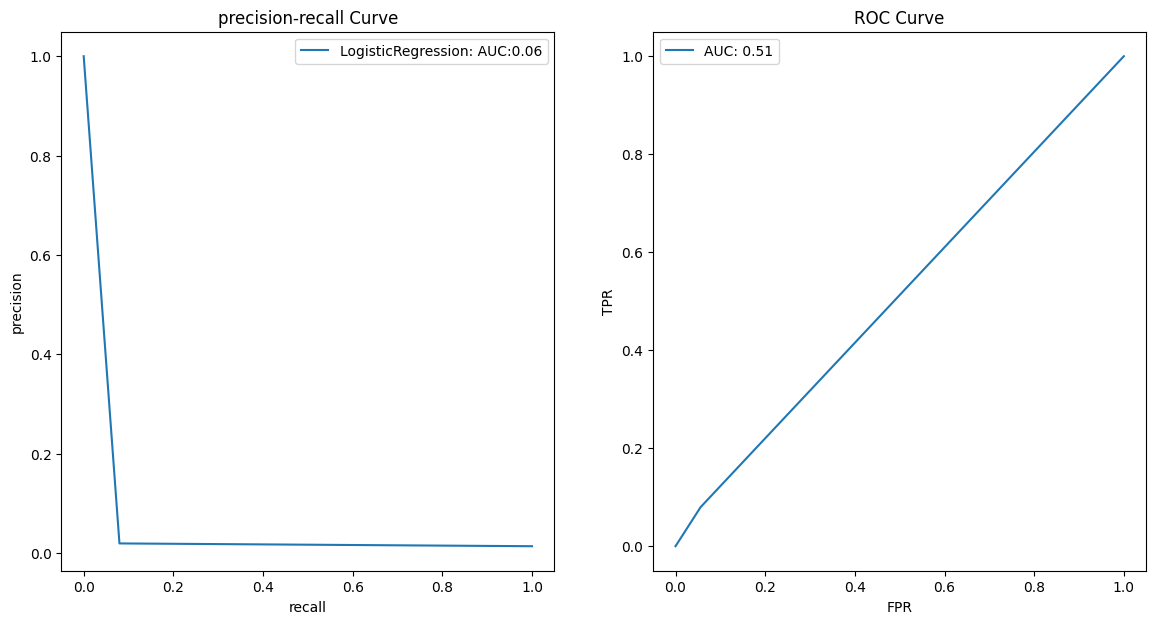

In [ ]:
y_test_pred = LogReg_model.predict_proba(x_test)

plot_metrics("LogisticRegression", y_pred=y_test_pred, y_test=y_test,model_estimator=LogReg_model,x_train=x_train,y_train=y_train)

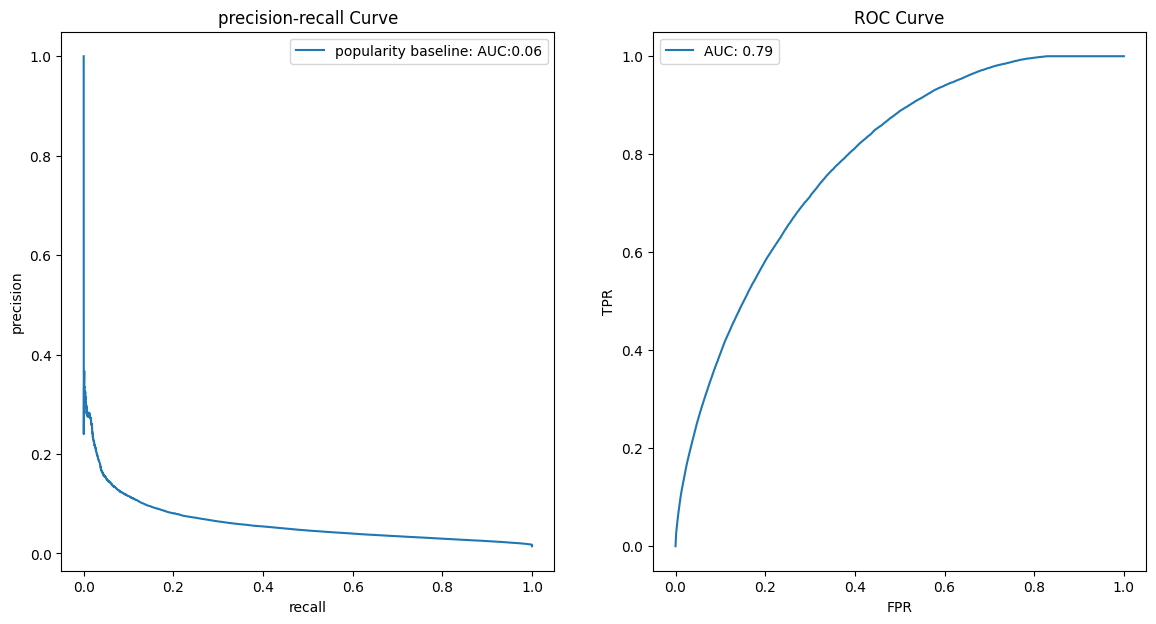

In [67]:
plot_metrics("popularity baseline", y_pred=feature_frame["global_popularity"], y_test=feature_frame["outcome"])

In [ ]:
fig1,ax1 = plt.subplots(1,2,figsize=(14,7))
fig1.subtitle("Train metrics")

fig2, ax2 = plt.subplots(1,2,figsize=(14,7))
fig2.suptitle("Validations metrics")

cs = [1e-8,1e-6,1e-4,1e-2,1,100,1e4,None]
for c in cs:
    lr = make_pipeline{
        StandardScaler(),
        LogisticRegresion(penalty="l2",C=c if c else 1.0),
    }
    lr.fit(x_train,y_train)
    train_proba = lr.predict_proba(x_train)[:,1]
    plot_metrics(
        f"LR; C={c}",y_pred=train_proba,y=test=train_df[label_col],figure=(fig1,ax1)
    )
    
    val_proba = lr.predict_proba(x_val)[:1]
    plot_metrics(
        f"LR; C={c}", y=pred=val_proba, y_test=val_df[label_col], figure={fig2, ax}
    )

plot_metrics(
    f"Baseline",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    figure=(fig2,ax2),
)

### RandomForestClassifier

### Test the model

### Save the model

In [ ]:
joblib.dump(model, "models/model_MVP_RandomForestClassifier_01.pkl")